# TFRecord 포맷
텐서플로가 대용량 데이터를 저장하고 효율적으로 읽기 위해 선호하는 포맷은 바로 **TFRecord**.  
TFRecord는 크기가 다른 연속된 이진 레코드를 저장하는 단순한 이진 포맷임  
각 레코드는
- 레코드 길이
- 길이가 올바른지 체크하는 CRC 체크섬(check sum)
- 실제 데이터
- 데이터를 위한 CRC 체크섬

으로 구성된다고 함.  
**tf.io.TFRecordWriter** 클래스를 사용해 TFRecord를 손쉽게 만들 수 있음

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [12]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print("\n---")
    print(item)


---
tf.Tensor(b'This is the first record', shape=(), dtype=string)

---
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


**tf.data.TFRecordDataset** 을 사용해 하나 이상의 TFRecord 를 읽을 수 있음.
> 또한 **num_parallel_reads** 를 지정하여 여러 파일에서 레코드를 번갈아 읽을 수도 있음.  
앞서 CSV파일에 했던 것처럼 **list_files()와 interleave()** 를 사용하여 동일한 결과를 얻을 수 있음

---
### 압축된 TFRecord파일 만들기
**options** 매개변수를 사용하여 압축된 TFRecord 파일을 만들 수 있음

In [4]:
options = tf.io.TFRecordOptions(compression_type="GZIP")

In [5]:
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"hi")

In [16]:
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"], compression_type="GZIP")
for item in dataset:
    print("\n---")
    print(item)


---
tf.Tensor(b'hi', shape=(), dtype=string)


압축된 TFRecord파일을 읽으려면 압축 형식을 지정해주면 됨

---
## 프로토콜 버퍼
각 레코드는 어떤 이진 포맷도 사용할 수 있지만 일반적으로 TFRecord는 직렬화된 **프로토콜 버퍼 (protobuf)** 를 담고 있음.  
프로토콜 버퍼는 이식성과 확장성이 좋고 효율적인 이진 포맷이라고 함. 널리 사용된다고 함.  
프로토콜 버퍼는 다음과 같이 정의됨 (C 언어인가?)

syntax = "proto3";  
message Person {  
    string name = 1;  
    int32 id = 2;  
    repeated string email = 3;  
}

In [18]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

In [40]:
person_example = Example(
    features = Features(
        feature={
            "name": Feature(bytes_list = BytesList(value=[b"Alice"])),
            "id": Feature(int64_list = Int64List(value=[123])),
            "emails": Feature(bytes_list = BytesList(value=[b"a@b.com",
                                                            b"c@d.com"]))
        }))

In [41]:
person_example

features {
  feature {
    key: "emails"
    value {
      bytes_list {
        value: "a@b.com"
        value: "c@d.com"
      }
    }
  }
  feature {
    key: "id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "name"
    value {
      bytes_list {
        value: "Alice"
      }
    }
  }
}

example 프로토콜 버퍼를 만들었음.  
이것을 **SerializeToString()** 메서드를 이용하여 직렬화하고 결과 데이터를 TFRecord 파일에 저장할 수 있음

In [42]:
with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())

In [43]:
dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"])
for item in dataset:
    print("\n---")
    print(item)


---
tf.Tensor(b'\n@\n\x11\n\x04name\x12\t\n\x07\n\x05Alice\n\x0b\n\x02id\x12\x05\x1a\x03\n\x01{\n\x1e\n\x06emails\x12\x14\n\x12\n\x07a@b.com\n\x07c@d.com', shape=(), dtype=string)


보통 하나 이상의 Example을 만들어야됨.  
1. 일반적으로 현재 포맷을 읽어 샘플마다 하나의 Example 프로토콜 버퍼 생성
2. 직렬화한 다음 프로세스에서 셔플링
3. TFRecord 파일 여러 개에 저장하는 변환 스크립트 작성

이는 작업량이 꽤 되므로 진짜로 필요할 때 적용하라고 함(??)

---
### 프로토콜 버퍼 읽고 파싱하기
직렬화된 Example 프로토콜 버퍼를 읽기 위해선 **tf.data.TFRecordDataset** 을 사용하고 또 **tf.io.parse_single_example()** 을 사용하면 됨.  
parse_single_example() 메서드는 두 개의 매개변수가 필요함.
1. 직렬화된 데이터를 담은 문자열 스칼라 텐서
2. 각 특성에 대한 설명 (각 특성 이름을 특성의 크기, 타입, 기본값을 표현한 **tf.io.FixedLenFeature** 나 특성의 타입만 표현한 **tf.io.VarLenFeature (길이가 가변적인 경우)** 에 매핑한 딕셔너리임)

In [37]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}

In [44]:
for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example, feature_description)
    print(parsed_example["name"])
    print(parsed_example["id"])
    print(parsed_example["emails"])

tf.Tensor(b'Alice', shape=(), dtype=string)
tf.Tensor(123, shape=(), dtype=int64)
SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64))


**가변 길이** 로 설정한 emails 특성은 제대로 표현이 안됨.  
>고정 길이 특성은 보통의 텐서로 바로 파싱되지만 가변 길이 특성은 **희소 텐서** 로 파싱되기 때문

**tf.sparse.to_dense()** 로 희소 텐서를 밀집 텐서로 변환할 수 있지만 여기에서는 희소 텐서의 값을 바로 참조하는 것이 더 간단하다고 함.

In [48]:
for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example, feature_description)
    print(parsed_example["name"])
    print(parsed_example["id"])
    print(parsed_example["emails"])
    print("")
    print(tf.sparse.to_dense(parsed_example["emails"], default_value=b""))
    print(parsed_example["emails"].values)

tf.Tensor(b'Alice', shape=(), dtype=string)
tf.Tensor(123, shape=(), dtype=int64)
SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64))

tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string)
tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string)


---
## 이미지 데이터 
**ByteList** 는 직렬화된 객체를 포함해 원하는 어떤 이진 데이터도 포함할 수 있음.  
>예를 들어 **tf.io.encode_jpeg** 를 사용해 JPEG 포맷 이미지를 인코딩하고 이 이진 데이터를 ByteList 에 넣을 수 있음.  
나중엔 코드에서 이 TFRecord를 읽을 때 Example을 파싱한 다음 데이터를 파싱하고 원본 이미지를 얻기 위해 **tf.io.decode_jpeg()** 를 호출하면 됨  
(또는 BMP, GIF, JPEG, PNG 이미지를 디코딩할 수 있는 **tf.io.decode_image** 를 사용해도 됨
  
> 또한 **tf.io.serialize_tensor()** 를 사용하여 어떤 텐서라도 직렬화하고 결과 바이트 스트링을 ByteList 특성에 넣어 저장할 수 있음.  
나중엔 이 TFRecord를 파싱할 때 **tf.io.parse_tensor** 를 사용하여 파싱하면 됨.  
  
 
> **tf.io.parse_single_example** 로 하나씩 파싱하는 대신 **tf.io.parse_example** 로 배치 단위로 파싱할 수도 있음.

In [49]:
dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(10)
for serialized_examples in dataset:
    parsed_example = tf.io.parse_example(serialized_examples,
                                        feature_description)
    print(parsed_example)

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x0000026027056760>, 'id': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([123], dtype=int64)>, 'name': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>}


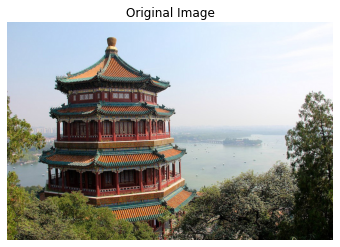

In [51]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images

img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

In [55]:
data = tf.io.encode_jpeg(img)
img_example = Example(
    features = Features(
        feature={
            "name": Feature(bytes_list = BytesList(value=[b"sample"])),
            "img": Feature(bytes_list = BytesList(value=[data.numpy()]))
        }))

serialized_example = img_example.SerializeToString()

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x01\xab\x02\x80\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x9

In [60]:
with tf.io.TFRecordWriter("my_img.tfrecord") as f:
    f.write(serialized_example)

In [61]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "img": tf.io.VarLenFeature(tf.string),
}

tf.Tensor(b'sample', shape=(), dtype=string)
(1,)
(427, 640, 3)


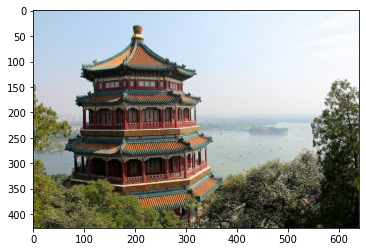

In [77]:
for serialized_example in tf.data.TFRecordDataset(["my_img.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example, feature_description)
    print(parsed_example["name"])
    
    img_string = parsed_example["img"].values
    print(img_string.shape)
    img_data = tf.io.decode_jpeg(img_string[0])
    print(img_data.shape)
    plt.imshow(img_data)

---
## SequenceExample 프로토콜 버퍼를 사용해 리스트의 리스트 다루기
대부분의 경우에 **Example** 프로토콜 버퍼로 충분함.  
하지만 리스트의 리스트를 다룰 때는 사용하기 어려움.  
예를 들어 텍스트 문서를 분류할 때 각 문서는 문장의 리스트로 표현됨. 그리고 각 문장은 단어의 리스트로 표현됨.  
또는 각 문서가 코멘트의 리스트를 가지고 각 코멘트는 단어의 리스트로 표현됨. 문서의 저자, 제목, 출간일 같은 문맥 데이터도 가질 수 있음.  
> 이런 경우를 대비해 텐서플로의 **SequenceExample** 프로토콜 버퍼가 있음

SequenceExample을 만들고 직렬화하고 파싱하는 것은 Example을 만들고 직렬화하고 파싱하는 것과 비슷함.  
- 하지만 하나의 SequenceExample을 파싱하려면 **tf.io.parse_single_sequence_example()** 사용
- 배치를 파싱하려면 **tf.io.parse_sequence_example()** 사용



In [89]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, FeatureList, FeatureLists, SequenceExample

In [81]:
context = Features(
    feature={
        "author_id": Feature(int64_list = Int64List(value=[123])),
        "title": Feature(bytes_list = BytesList(value=[b"A", b"desert", b"place", b"."])),
        "pub_date": Feature(int64_list = Int64List(value=[1623, 12, 25])),
    })

In [82]:
content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

In [83]:
def words_to_feature(words):
    return Feature(bytes_list = BytesList(value = [word.encode("utf-8") for word in words]))

In [85]:
content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]

In [90]:
sequence_example = SequenceExample(
    context = context,
    feature_lists = FeatureLists(feature_list={
        "content": FeatureList(feature=content_features),
        "comments": FeatureList(feature=comments_features)
    }))

In [93]:
sequence_example.context

feature {
  key: "author_id"
  value {
    int64_list {
      value: 123
    }
  }
}
feature {
  key: "pub_date"
  value {
    int64_list {
      value: 1623
      value: 12
      value: 25
    }
  }
}
feature {
  key: "title"
  value {
    bytes_list {
      value: "A"
      value: "desert"
      value: "place"
      value: "."
    }
  }
}

In [94]:
sequence_example.feature_lists

feature_list {
  key: "comments"
  value {
    feature {
      bytes_list {
        value: "When"
        value: "the"
        value: "hurlyburly"
        value: "\'s"
        value: "done"
        value: "."
      }
    }
    feature {
      bytes_list {
        value: "When"
        value: "the"
        value: "battle"
        value: "\'s"
        value: "lost"
        value: "and"
        value: "won"
        value: "."
      }
    }
  }
}
feature_list {
  key: "content"
  value {
    feature {
      bytes_list {
        value: "When"
        value: "shall"
        value: "we"
        value: "three"
        value: "meet"
        value: "again"
        value: "?"
      }
    }
    feature {
      bytes_list {
        value: "In"
        value: "thunder"
        value: ","
        value: "lightning"
        value: ","
        value: "or"
        value: "in"
        value: "rain"
        value: "?"
      }
    }
  }
}

In [98]:
serialized_sequence = sequence_example.SerializeToString()
with tf.io.TFRecordWriter("my_sequence.tfrecord") as f:
    f.write(serialized_sequence)

In [97]:
context_description = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0])
}

feature_lists_description = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}

In [106]:
for serialized_sequence in tf.data.TFRecordDataset(["my_sequence.tfrecord"]):
    parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
        serialized_sequence, context_description, feature_lists_description)
    print(parsed_context)
    print(parsed_context["title"].values)
    print("")
    print(parsed_feature_lists)
    print(parsed_feature_lists["content"].values)
    print(tf.RaggedTensor.from_sparse(parsed_feature_lists["content"]))

{'title': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x000002602B450940>, 'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'pub_date': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1623,   12,   25], dtype=int64)>}
tf.Tensor([b'A' b'desert' b'place' b'.'], shape=(4,), dtype=string)

{'comments': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x000002602B450670>, 'content': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x000002602B450B80>}
tf.Tensor(
[b'When' b'shall' b'we' b'three' b'meet' b'again' b'?' b'In' b'thunder'
 b',' b'lightning' b',' b'or' b'in' b'rain' b'?'], shape=(16,), dtype=string)
<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'], [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>
